In [54]:
import os
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt


import torch
import torchvision
from torch import nn
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [55]:
def set_seeds(seed_no:int=42):
    torch.manual_seed(seed_no)

In [56]:
train_data_path = Path(r"C:\Users\bamilosin\Documents\dataset\vision\food vision data\pizza_steak_sushi-20%\train")
test_data_path = Path(r"C:\Users\bamilosin\Documents\dataset\vision\food vision data\pizza_steak_sushi-20%\test")

BATCH_SIZE = 32
transforms = T.Compose([
    T.ToImage(),
    T.Resize((224,224)),
    T.ToDtype(torch.float, scale=True)
])

train_dataset = ImageFolder(train_data_path, transform=transforms)
test_dataset = ImageFolder(test_data_path, transform=transforms)

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())

In [57]:
images, labels = next(iter(train_dataloader))

In [58]:
idx_to_class = {value : label for label, value in train_dataset.class_to_idx.items()}
idx_to_class

{0: 'pizza', 1: 'steak', 2: 'sushi'}

### plot random samples from data

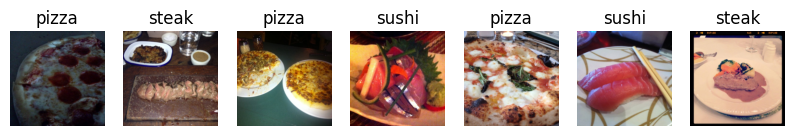

In [59]:
samples = torch.randperm(len(train_dataset))[:7]
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(10,5))
for i,sample in enumerate(samples):
    image = train_dataset[sample][0].permute(1,2,0)
    axs[i].imshow(image)
    label = idx_to_class[train_dataset[sample][1]]
    axs[i].set_title(label)
    axs[i].axis("off")
plt.show()

### Replicating ViT
In order to make research paper's more understandable, break it down into simpler pieces

Inputs: what goes into the model? (in our case, image tensors)

Outputs: what comes out of the model/layer/block? (in our case, we want the model to output image classification labels)

Layers: Takes an input, manipulates it with a function (for example could be self-attention)

Blocks: A collection of layers

Model: A collection of Blocks


### ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
 

Equation 1

x_input = [class_token, image_patch1, image_patch2 ... image_patch_N] + [class_token_pos, image_patch1_pos, image_patch2_pos ... image_patch_N_pos]

Equation 2

x_output_msa_block = MSA_layer(LN_layer(x_input)) + x_input

Equation 3

x_output_mlp_block = mlp_layer(ln_layer(x_output_msa_block)) + x_output_msa_block

Equation 4

y = linear_layer(ln_layer(x_output_mlp_block))

## Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the Output shape?

* Input Image: $H\times{W}\times{C}$ (height x width color x channels)
* Output Image: ${N \times\left(P^{2} \cdot C\right)}$ 
* Height = height
* Width = width
* C = Color Channels
* P = Patch Size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension 

In [60]:
# create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# calculate number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [61]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"input shape (single 2d image): {embedding_layer_input_shape}")
print(f"output shape (single 1d sequence of patches): {embedding_layer_output_shape} -> (number_of_image_patches, embedding_dim)")

input shape (single 2d image): (224, 224, 3)
output shape (single 1d sequence of patches): (196, 768) -> (number_of_image_patches, embedding_dim)


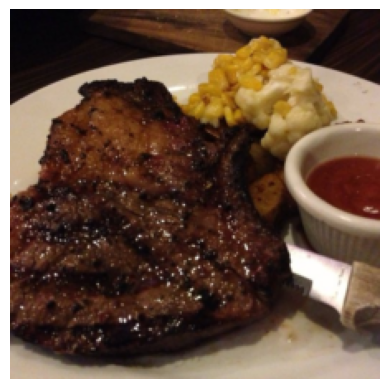

torch.Size([3, 224, 224])


In [62]:
image = images[16]
plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.show()

print(image.shape)

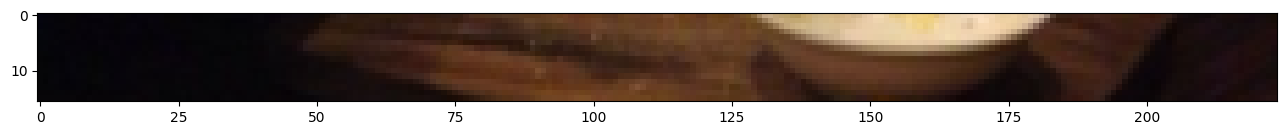

In [63]:
# get the top row of pixels
image_permuted = image.permute(1,2,0) # H x W x C

# index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

In [64]:
image_permuted.shape

torch.Size([224, 224, 3])

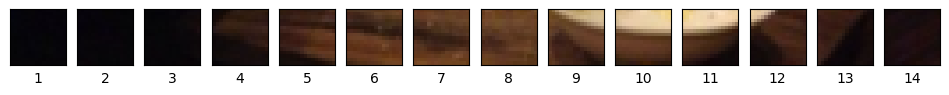

In [65]:
# setup code to plot image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# create subplots
fig, axs = plt.subplots(nrows=1, ncols=img_size//patch_size, sharex=True, sharey=True, figsize=(12,5))

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

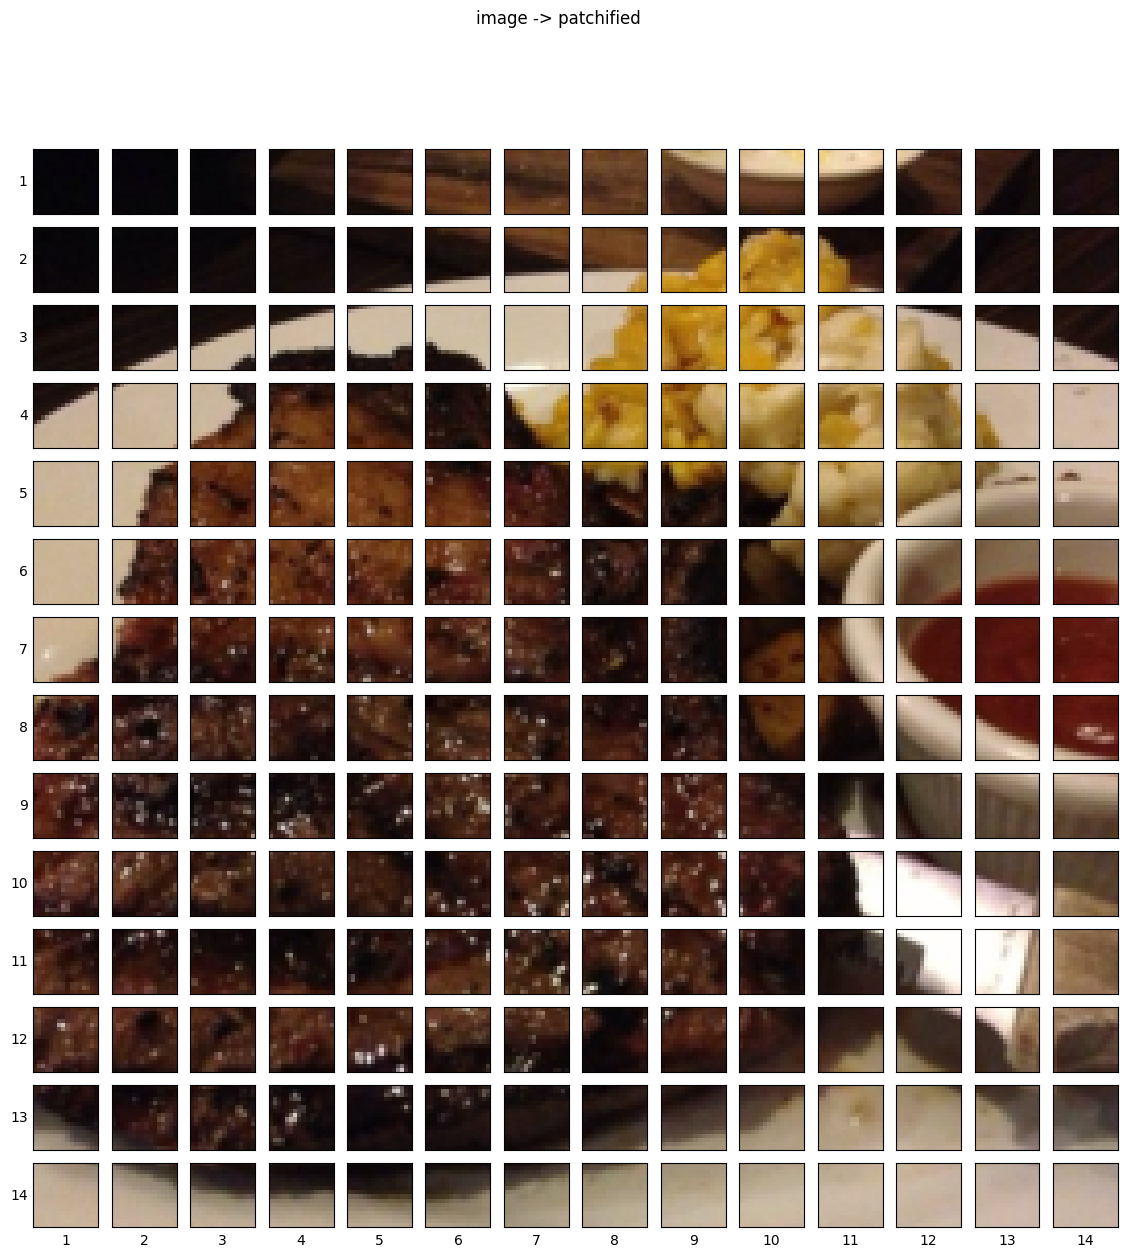

In [66]:
## visualize all patches
fig, axs = plt.subplots(nrows=int(num_patches), ncols=int(num_patches), sharex=True, sharey=True, figsize=(num_patches, num_patches))

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
        # setup label information for each subplot
        axs[i,j].set_ylabel(i+1,
                            rotation="horizontal",
                            horizontalalignment='right',
                            verticalalignment='center')
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

# set up title for the plot
fig.suptitle(f"image -> patchified")
plt.show()

## create patch embeddings 

use a conv layer to generate patch embeddings, using the kernel size as patch size, and stride as patch size

In [67]:
# create a conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# set the patch size
patch_size = 16

# create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, # D
                   kernel_size=patch_size,
                   stride = patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

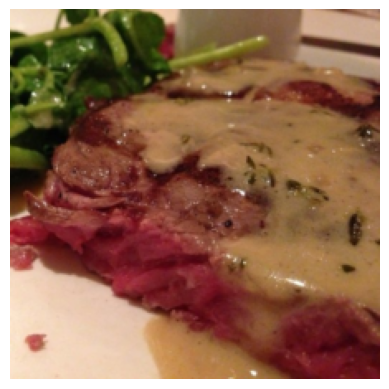

In [68]:
# view single image
image = images[9]
plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.show()

In [69]:
# pass image through conv2d layer
img_out_of_conv = conv2d(image.unsqueeze(0))
img_out_of_conv.size()

torch.Size([1, 768, 14, 14])

Now we've passed a single image into ur Conv2d layer, it's shape is:

```python
torch.Size([1,768,14,14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

In [70]:
img_out_of_conv.requires_grad

True

### view feature maps

showing random convolutional feature maps from indexes: [169, 688, 669, 94, 11, 132]


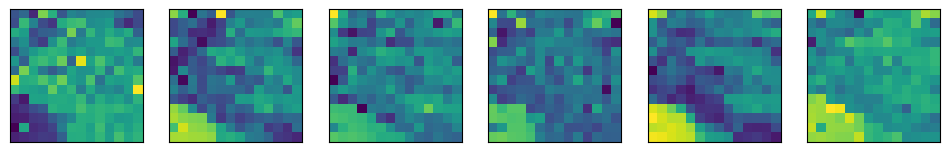

In [71]:
# plot random convolutional feature maps
import random
k=6
random_index = random.sample(range(0, 758), k=k)
print(f"showing random convolutional feature maps from indexes: {random_index}")

# create plot
fig, axs = plt.subplots(nrows=1, ncols=len(random_index), figsize=(12,12))
for i, idx in enumerate(random_index):
    img_conv_feat_map = img_out_of_conv[:, idx, :, :]
    axs[i].imshow(img_conv_feat_map.squeeze().detach().numpy()) # remove batch dim, remove grad tracking and switch to np for plt
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.show()

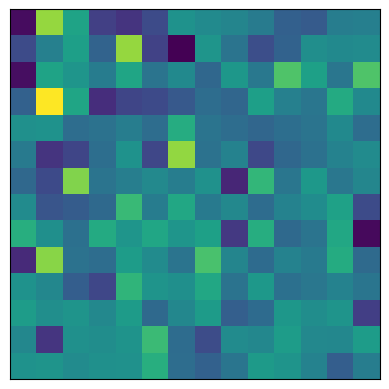

In [72]:
test = img_out_of_conv[:, 0, :, :]
plt.imshow(test.permute(1,2,0).squeeze(0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

Flattening patch embeddings with ```torch.nn.Flatten()```

In [73]:
test.shape

torch.Size([1, 14, 14])

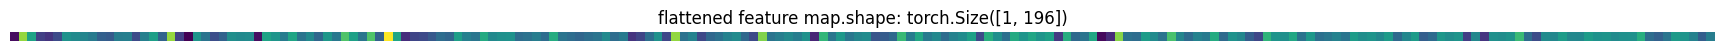

In [74]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flattened_feat_map = flatten_layer(img_out_of_conv).permute(0,2,1)
single_flattened_feat_map = flattened_feat_map[:,:,0]

# plot flattened embeddings
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feat_map.detach().numpy())
plt.title(f"flattened feature map.shape: {single_flattened_feat_map.shape}")
plt.axis('off')
plt.show()

#### Patch Embedding Layer

In [75]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super(PatchEmbedding, self).__init__()

        self.patch_size = patch_size
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        self.flat = nn.Flatten(start_dim=2, end_dim=-1)

    def forward(self, x):
        img_resolution = x.shape[-1]
        # image resolution must be divisible by patch size
        assert img_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {img_resolution}, patch size: {patch_size}"
        
        features = self.patcher(x)
        flat_features = self.flat(features)
        return flat_features.permute(0,2,1)

In [76]:
set_seeds()
image  = images[0]
patchify = PatchEmbedding()
# pass a single image through patch embedding layer
print(f"Input image size: {image.shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


### Adding class tokens

want to: prepend a learnable class token to the start of each embedding

In [77]:
# get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]
batch_size, embedding_dim

(1, 768)

In [78]:
# create the class token embedding as a learnable parameter that shares the same size as the the embedding dimension
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)
class_token.shape


torch.Size([1, 1, 768])

In [79]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [80]:
# add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)  # number of patches dim
print(f"number of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

number of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### create position embeddings

In [81]:
# calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)

# get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                   requires_grad=True)
position_embedding.shape

torch.Size([1, 197, 768])

In [82]:
# add position embedding to patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(patch_and_position_embedding.shape)


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6508, 1.0502, 0.9116,  ..., 1.1239, 0.8572, 1.1864],
         [0.5171, 1.1758, 1.0060,  ..., 1.2286, 0.7530, 1.1044],
         ...,
         [0.1308, 1.1827, 0.7455,  ..., 1.6190, 0.6157, 1.3425],
         [0.1233, 1.2046, 0.7566,  ..., 1.6242, 0.6129, 1.3268],
         [0.1875, 1.1514, 0.7174,  ..., 1.5830, 0.5907, 1.3219]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 197, 768])


### Equation 1, all together

In [ ]:
set_seeds()

# 1. set the patch size
patch_size = 16

# 2. print shapes of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"patch embedding shape: {patch_embedding.shape}")

# 6. create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                               requires_grad=True) # make sure it is learnable
print(f"class token embedding shape: {class_token.shape}")

# 7. prepend class token to patch embeddings
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"patch and position embedding shape: {patch_and_position_embedding.shape}")



Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
patch embedding shape: torch.Size([1, 196, 768])
class token embedding shape: torch.Size([1, 1, 768])
patch embedding with class token shape: torch.Size([1, 197, 768])
patch and position embedding shape: torch.Size([1, 197, 768])


### Equation 2: Multihead Self Attention